In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Chargement de données
Nous utiliserons directement les données prétraitées dans la partie 3. Dans la partie 3, les données sont numérisées, et les valeurs manquantes emputées. Nous avions enlevé les gardients du jeu de données car ils n'ont pas les même caractéristiques que les autres joueurs. 

In [2]:
df = pd.read_csv('data/data_cleaned.csv')
df.head()

,Unnamed: 0,height_cm,weight_kg,overall_rating,potential,weak_foot,skill_moves,international_reputation,dribbling,passing,...,groupe_age_20-25,groupe_age_25-30,groupe_age_30-35,groupe_age_<20,groupe_age_>35,club_position_cat_DEF,club_position_cat_FWD,club_position_cat_MID,club_position_cat_SUB,release_clause_num
0,0,190,82,91,91,4,3,5.0,64.0,86.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,213700000.0
1,1,175,72,91,91,3,4,5.0,59.0,81.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,192400000.0
2,2,186,75,90,94,4,4,5.0,50.0,83.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,370800000.0
3,3,195,94,90,92,3,3,5.0,72.0,81.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,302200000.0
4,4,176,73,90,94,4,5,5.0,55.0,58.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,364400000.0


# AutoML pour la Prédiction

In [3]:
predict_col = ['wage_cat', 'wage_clean', 'value_num', 'value_cat']

numeric_col = ['height_cm', 'weight_kg', 'overall_rating', 'potential', 'skill_moves',
       'international_reputation', 'dribbling', 'passing', 'shooting', 'weak_foot',
       'defending', 'physic', 'age', 'IMC','duree_contrat', 'release_clause_num']

categorical_col = [col for col in df.columns if not col in numeric_col and not col in predict_col]

### Répartition des classes 

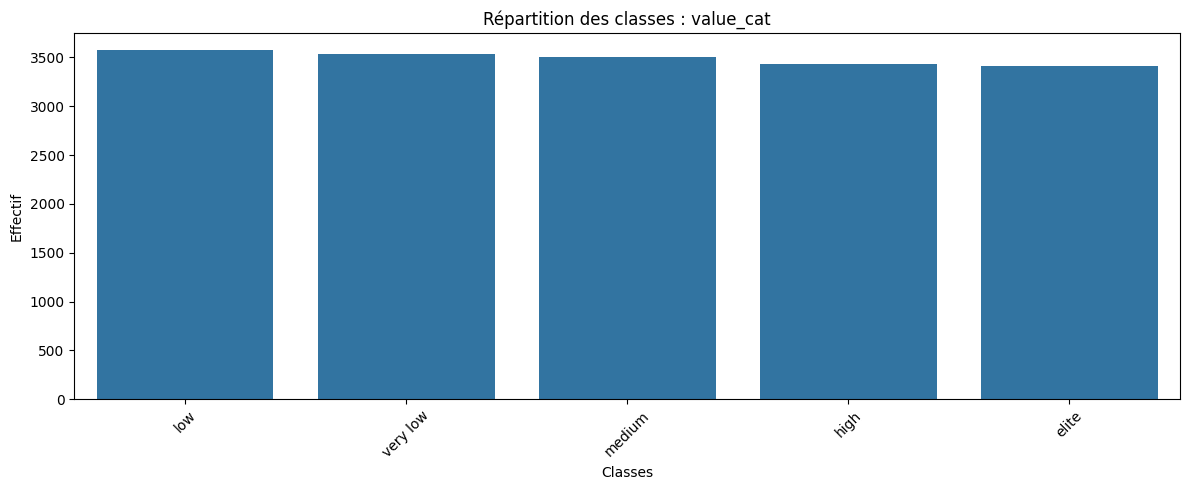

In [4]:
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 1, 1)
sns.countplot(data=df, x='value_cat', order=df['value_cat'].value_counts().index)
plt.title("Répartition des classes : value_cat")
plt.xlabel("Classes")
plt.ylabel("Effectif")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Les classes sont réparties uniformement, ce qui est déjà un bon point. 

## Préparation de l'espace de recherche de des pipelines
Nous utiliserons l'outils `TPOT` pour l'optimisation. Nous définirons l'espace de recherche suivant : 
> XGBoost : 
- max_depth : $[2,20]$
- n_estimators :  $[300, 1000]$
- eta :  $[0.01, 0.3]$
> RandomForest : 
- n_estimators : $[300, 1000]$
- 'max_depth' : $[2,20]$
- criterion : gini, entropy et log_loss
    

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import tpot
from ConfigSpace import ConfigurationSpace, Integer, Float, Categorical
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_col),
        ('cat', 'passthrough', categorical_col)
    ]
)

X = preprocess.fit_transform(df.drop(columns=predict_col))
y = df['value_cat']
labels_mapping = {label: idx for idx, label in enumerate(y.unique())}
y_encoded = y.map(labels_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.33, random_state=42)

# Espace de recherche 
rf_configspace = ConfigurationSpace(
    space = {
        'n_estimators': Integer("n_estimators", bounds=(300, 1000)),
        'max_depth': Integer("max_depth", bounds=(2, 15)),
        'criterion': Categorical("criterion", ['gini', 'entropy', 'log_loss']),
        'n_jobs': 1
    }
)

xgb_configspace = ConfigurationSpace(
    space = {
        'n_estimators': Integer("n_estimators", bounds=(500, 1000)),
        'max_depth': Integer("max_depth", bounds=(3, 10)),
        'eta': Float("eta", bounds=(0.03, 0.3)),
    }
) 


rf_node = tpot.search_spaces.nodes.EstimatorNode(
    method = RandomForestClassifier,
    space = rf_configspace,
)
xgb_node = tpot.search_spaces.nodes.EstimatorNode(
    method = XGBClassifier,
    space = xgb_configspace,
)

classifier_node = tpot.search_spaces.pipelines.ChoicePipeline(
    search_spaces=[
        rf_node,
        xgb_node
    ]
)

/home/bechir/miniconda3/envs/Automl1/lib/python3.10/site-packages/stopit/__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [6]:
from tpot import TPOTClassifier

tpot_classifier3 = TPOTClassifier(
    generations=10,
    population_size=15,
    cv=5,
    scorers=['accuracy', 'roc_auc_ovr'],
    scorers_weights=[1/2, 1/2],
    random_state=42,
    search_space=classifier_node,
)

tpot_classifier3.fit(X_train, y_train)


/home/bechir/miniconda3/envs/Automl1/lib/python3.10/site-packages/tpot/tpot_estimator/estimator.py:458: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
Generation:   0%|          | 0/10 [00:00<?, ?it/s]/home/bechir/miniconda3/envs/Automl1/lib/python3.10/site-packages/stopit/__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Generation:  70%|███████   | 7/10 [1:00:37<25:58, 519.59s/it]


,search_space,<tpot.search_...x7fac6570ce20>
,scorers,"['accuracy', 'roc_auc_ovr']"
,scorers_weights,"[0.5, 0.5]"
,cv,5
,other_objective_functions,[]
,other_objective_functions_weights,[]
,objective_function_names,None
,bigger_is_better,True
,categorical_features,None
,memory,None
,preprocessing,False


In [13]:
labels_mapping

{'elite': 0, 'very low': 1, 'high': 2, 'medium': 3, 'low': 4}

In [7]:
best_model = tpot_classifier3.fitted_pipeline_

best_score = best_model.score(X_test, y_test)

print("Best Model:", best_model)
print("Best Score on Test Set:", best_score)

Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1046981249386, eval_metric=None,
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=577, n_jobs=None, ...)
Best Score on Test Set: 0.9571403782752039


ROC AUC Score (OvR): 0.998219810967713
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      1103
           1       0.98      0.97      0.98      1147
           2       0.94      0.95      0.95      1153
           3       0.94      0.93      0.93      1165
           4       0.95      0.95      0.95      1195

    accuracy                           0.96      5763
   macro avg       0.96      0.96      0.96      5763
weighted avg       0.96      0.96      0.96      5763



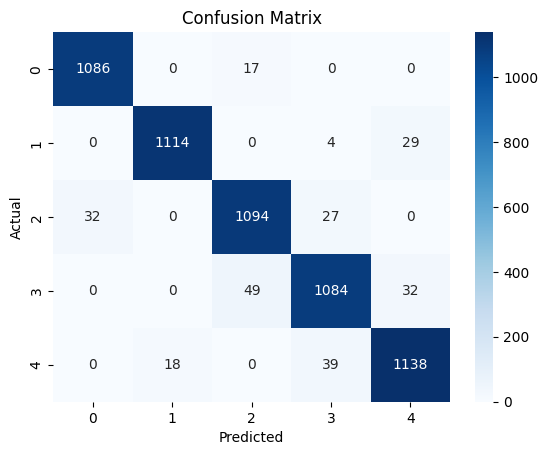

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

y_pred = best_model.predict(X_test)
print("ROC AUC Score (OvR):", roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr'))
print("Classification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## AutoML pour le Clustering
### Préparation de données

Comme fait dans la partie 2 du projet, nous allons faire l'étude sur uniquement les variables numérique en excluant les colonnes Player Value, Wage et Overall Rating. Pour faire simple, nous allons réutiliser les données traitées et nétoyées dans la partie 2. 

In [2]:
df_clustering = pd.read_csv('data/data_for_clustering.csv')
df_clustering.head()

,height_cm,weight_kg,potential,skill_moves,international_reputation,club_rating,dribbling,passing,shooting,defending,...,wage_cat_encoded,value_cat_encoded,club_position_cat_DEF,club_position_cat_FWD,club_position_cat_MID,club_position_cat_SUB,country_position_cat_DEF,country_position_cat_FWD,country_position_cat_MID,country_position_cat_SUB
0,1.232186,1.037643,3.229681,0.764344,10.602002,3.221583,0.777479,2.411845,2.459952,-1.429128,...,4.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.990277,-0.439072,3.229681,2.120475,10.602002,3.022002,0.131836,2.010854,2.709949,-1.149371,...,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.639530,0.003942,3.718651,2.120475,10.602002,3.221583,-1.030322,2.171250,2.272453,-1.149371,...,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.973007,2.809701,3.392671,0.764344,10.602002,3.221583,1.810509,2.010854,2.584950,-1.037468,...,4.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-0.842113,-0.291401,3.718651,3.476606,10.602002,3.221583,-0.384678,2.022113,-1.540013,7.687963,...,4.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Espace de recherche pour le K-means

In [4]:
from hyperopt import hp
search_spaces = {
    "n_clusters": hp.choice("n_clusters", np.arange(3, 10)),
    "init": hp.choice("init", ["k-means++", "random"]),
    "n_init": hp.choice("n_init", [10, 20, 30, 40, 50]),
    "max_iter": hp.choice("max_iter", [100, 200, 300, 400, 500]),
    "algorithm": hp.choice("algorithm", ['elkan', 'lloyd']),
}

In [5]:
from sklearn.cluster import KMeans
from hyperopt import fmin, tpe, Trials, STATUS_OK
from sklearn.metrics import silhouette_score

# Utilisation de l'indice de silhouette comme métrique d'évaluation

X_clust = df_clustering.values.copy()

def objective(params):
    kmeans = KMeans(**params)
    kmeans.fit(X_clust)
    silhouette_avg = silhouette_score(X_clust, kmeans.labels_)
    return {'loss': -silhouette_avg, 'status': STATUS_OK}


In [6]:
trials = Trials()
best_hp = fmin(
    fn=objective,
    space=search_spaces,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

print(f"Les meilleurs hyperparatres trouver :\n{best_hp}")

100%|██████████| 100/100 [07:57<00:00,  4.77s/trial, best loss: -0.1304045350013539]
Les meilleurs hyperparatres trouver :
{'algorithm': 0, 'init': 1, 'max_iter': 0, 'n_clusters': 1, 'n_init': 2}


In [13]:
# Hyperparamètres optimaux
optimal_params = {
    'n_clusters': np.arange(3, 10)[best_hp['n_clusters']],
    'init': ["k-means++", "random"][best_hp['init']],
    'n_init': [10, 20, 30, 40, 50][best_hp['n_init']],
    'max_iter': [100, 200, 300, 400, 500][best_hp['max_iter']],
    'algorithm': ['elkan', 'lloyd'][best_hp['algorithm']],
}
print("Optimal Hyperparameters:", optimal_params)

Optimal Hyperparameters: {'n_clusters': 4, 'init': 'random', 'n_init': 30, 'max_iter': 100, 'algorithm': 'elkan'}


In [14]:
km = KMeans(**optimal_params)
km.fit(X_clust)
labels = km.labels_
df_clustering['Cluster'] = labels
df_clustering.head()

,height_cm,weight_kg,potential,skill_moves,international_reputation,club_rating,dribbling,passing,shooting,defending,...,value_cat_encoded,club_position_cat_DEF,club_position_cat_FWD,club_position_cat_MID,club_position_cat_SUB,country_position_cat_DEF,country_position_cat_FWD,country_position_cat_MID,country_position_cat_SUB,Cluster
0,1.232186,1.037643,3.229681,0.764344,10.602002,3.221583,0.777479,2.411845,2.459952,-1.429128,...,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
1,-0.990277,-0.439072,3.229681,2.120475,10.602002,3.022002,0.131836,2.010854,2.709949,-1.149371,...,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,0.639530,0.003942,3.718651,2.120475,10.602002,3.221583,-1.030322,2.171250,2.272453,-1.149371,...,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
3,1.973007,2.809701,3.392671,0.764344,10.602002,3.221583,1.810509,2.010854,2.584950,-1.037468,...,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
4,-0.842113,-0.291401,3.718651,3.476606,10.602002,3.221583,-0.384678,2.022113,-1.540013,7.687963,...,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


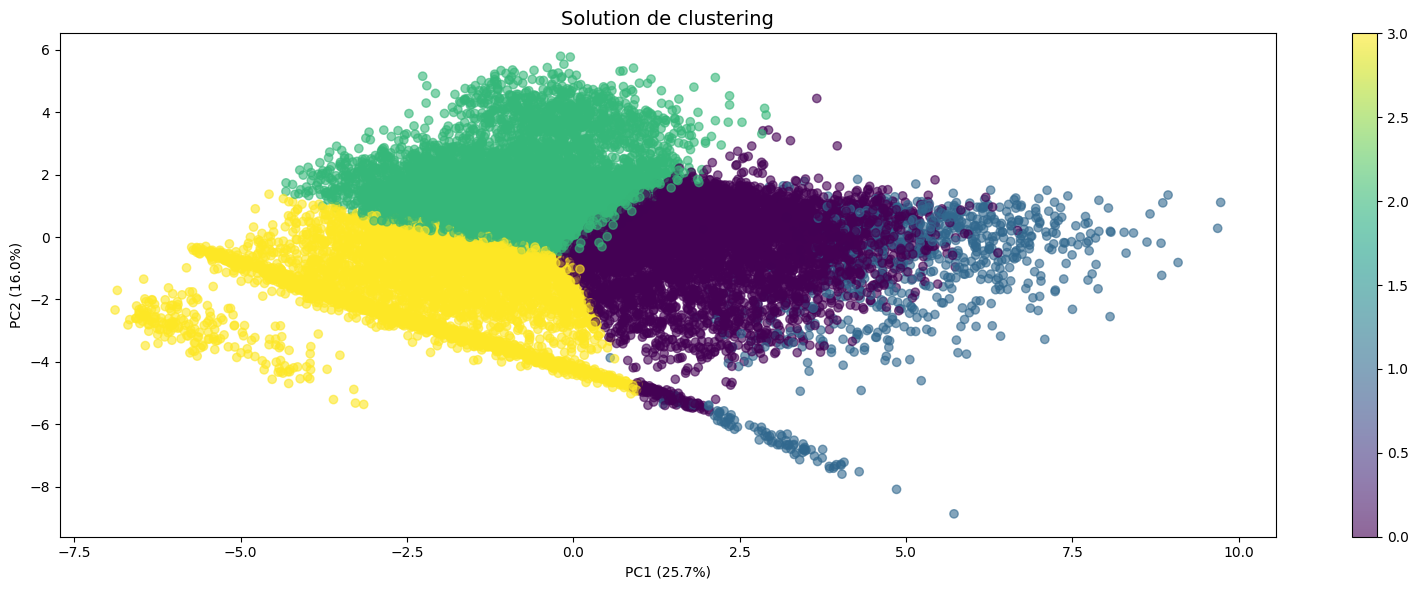

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clust)

fig, axes = plt.subplots(1, 1, figsize=(16, 6))

# Visualisation C1
scatter1 = axes.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
axes.set_title(f'Solution de clustering', fontsize=14)
axes.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.colorbar(scatter1, ax=axes)
plt.tight_layout()
plt.show()